In [1]:
#Standard packages
import numpy as np
import pandas as pd

#Plotting packages
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp


import networkx as nx
import quantstats as qs


In [3]:
df = pd.read_parquet('Stock_price_data.parquet')

df_2 = df.filter(regex=r'Adj Close')

df_2.index = pd.to_datetime(df_2.index)

df_2000_2018 = df_2.loc['2000-01-01':'2018-12-31']
df_2019_2023 = df_2.loc['2019-01-01':'2022-12-31']

df_2.head()

Adj Close                                  \
                                   A         AA       AAIC      AAME   
Date                                                                   
2000-01-03 00:00:00-05:00  44.290768  72.063606  24.392229  2.125906   
2000-01-04 00:00:00-05:00  40.907444  72.397484  22.466522  2.183363   
2000-01-05 00:00:00-05:00  38.369949  76.571045  22.466522  2.240821   
2000-01-06 00:00:00-05:00  36.908974  75.569412  22.680487  2.125906   
2000-01-07 00:00:00-05:00  39.984726  75.346786  24.820164  2.183363   

                                                                             \
                               AAON      AAPL        AB       ABC      ABCB   
Date                                                                          
2000-01-03 00:00:00-05:00  0.997502  0.859423  6.228925  3.025872  5.879150   
2000-01-04 00:00:00-05:00  1.039065  0.786965  6.202757  2.819288  5.810787   
2000-01-05 00:00:00-05:00  1.048301  0.798481  6.228925  3.038026  5.810787   
2000-01-06 00:00:00-05:00  1.052919  0.729382  6.333615  3.268915  5.810787   
2000-01-07 00:00:00-05:00  1.015974  0.763932  6.542994  3.694239  5.879150   

                                         ...                                 \
                                   ABEO  ...      YORW        YPF       YUM   
Date                                     ...                                  
2000-01-03 00:00:00-05:00  10901.087891  ...  2.744372  11.532703  4.861753   
2000-01-04 00:00:00-05:00  10122.438477  ...  2.744372  11.453301  4.764031   
2000-01-05 00:00:00-05:00  10122.438477  ...  2.724193  11.512856  4.788458   
2000-01-06 00:00:00-05:00  11679.737305  ...  2.724193  11.433455  4.747740   
2000-01-07 00:00:00-05:00  11679.737305  ...  2.724193  11.552554  4.641874   

                                                                              \
                               YVR       ZBRA        ZD      ZEUS       ZION   
Date                                                                           
2000-01-03 00:00:00-05:00  45.3125  25.027779  5.652174  4.378227  39.500340   
2000-01-04 00:00:00-05:00  42.1875  24.666668  5.326087  4.378227  37.587597   
2000-01-05 00:00:00-05:00  42.1875  25.138889  5.108696  4.378227  37.543118   
2000-01-06 00:00:00-05:00  39.0625  23.777779  5.380435  4.264506  38.076908   
2000-01-07 00:00:00-05:00  40.6250  23.513889  5.326087  4.548805  38.165886   

                                               
                                ZNH       ZTR  
Date                                           
2000-01-03 00:00:00-05:00  5.888203  2.461164  
2000-01-04 00:00:00-05:00  5.957072  2.484383  
2000-01-05 00:00:00-05:00  5.784901  2.487198  
2000-01-06 00:00:00-05:00  5.922637  2.510662  
2000-01-07 00:00:00-05:00  5.991505  2.557591  

[5 rows x 1817 columns]

### Functions for the portfolio balance

In [16]:
def calculate_correlations(df, start_year, end_year):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    
    # Find the first and last trading days within the specified range
    valid_dates = df.loc[start_date:end_date].index
    if not valid_dates.empty:
        start_date = valid_dates[0]
        end_date = valid_dates[-1]
    
    sliced_df = df.loc[start_date:end_date]
    return sliced_df.corr()

def create_correlation_graph(correlations, threshold):
    G = nx.Graph()
    for i in range(correlations.shape[0]):
        for j in range(i + 1, correlations.shape[1]):
            if correlations.iloc[i, j] > threshold:
                G.add_edge(correlations.columns[i], correlations.columns[j])
    return G


def find_independent_nodes(graph):
    independent_nodes = set()

    nodes_sorted_by_degree = sorted(graph.nodes, key=lambda node: graph.degree(node))

    for node in nodes_sorted_by_degree:
        if all(neighbor not in independent_nodes for neighbor in graph.neighbors(node)):
            independent_nodes.add(node)

    return independent_nodes

def portfolios(dataframe, start_year, end_year, correlation_years, correlation_threshold): # function that gives us a list of portfolios

    number_of_portfolios=end_year-start_year-correlation_years+1

    list_of_portfolios = [set() for _ in range(number_of_portfolios)]
    i=0

    for year in range(start_year+correlation_years, end_year+1 ):
        start_date =year-correlation_years
        end_date = year -1 


        correlations = calculate_correlations(dataframe, start_date, end_date) # correlations of the x previous years
        
        correlation_graph = create_correlation_graph(correlations, correlation_threshold) # create the correlation graph
        
        independent_nodes=find_independent_nodes(correlation_graph.copy()) # obtain the independent nodes
        
        list_of_portfolios[i].update(independent_nodes) 

        i+=1

    return  list_of_portfolios # returns_df


def calculate_daily_returns(assets_array, df, start_year):
    all_returns_list = []
    for i, asset_set in enumerate(assets_array):
        # Determine the year for this set of assets
        year = start_year + i
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        
        # Extract the relevant columns for the current set of assets
        columns = list(asset_set)
        
        # Slice the DataFrame to include only the current year and selected columns
        sliced_df = df.loc[start_date:end_date, columns]
        
        # Calculate the daily returns
        daily_returns = sliced_df.pct_change().dropna()
        
        mean_dayly_returns = daily_returns.mean(axis=1)

        all_returns_list.append(mean_dayly_returns)

    all_returns=pd.concat(all_returns_list, ignore_index=False)
    
    return all_returns

def mean_length_of_sets(sets_of_portfolios):
    lengths = [len(asset_set) for asset_set in sets_of_portfolios]
    mean_length = np.mean(lengths) if lengths else 0
    return mean_length

def first_portfolio(dataframe, start_year,  correlation_years, correlation_threshold):

    portfolio = set()

    start_date =start_year
    end_date = start_year+ correlation_years-1
    
    correlations = calculate_correlations(dataframe, start_date, end_date)
    
    correlation_graph = create_correlation_graph(correlations, correlation_threshold)
    
    independent_nodes = find_independent_nodes(correlation_graph.copy())
    
    portfolio.update(independent_nodes)
    
    return list(portfolio)
    



In [8]:
start_year=2000
end_year=2004
correlation_years=3
number_of_portfolios=end_year-start_year-correlation_years+1
print(number_of_portfolios)

sets=portfolios(df_2, start_year, end_year, correlation_years, 0.2)
print(len(sets))




2
2


### Rebalance of the portfolio

In [4]:

start_year = 2000
end_year = 2018

threshold_array=[0.2,0.3,0.4]
years_array=[1,2,3]

sharpe_ratio_map=[]
num_of_assets_map=[]


for threshold in threshold_array:
    sharpe_ratio_array=[]
    num_of_assets_array=[]
    for years in years_array:
        print(threshold, years)
        sets_of_portfolios= portfolios(df_2, start_year, end_year, years, threshold)
        
        returns=calculate_daily_returns(sets_of_portfolios, df_2, start_year+years)

        sharpe_ratio_array.append(qs.stats.sharpe(returns))
        num_of_assets_array.append(mean_length_of_sets(sets_of_portfolios))

    sharpe_ratio_map.append(sharpe_ratio_array)
    num_of_assets_map.append(num_of_assets_array)

sharpe_ratio_map=np.array(sharpe_ratio_map)
num_of_assets_map=np.array(num_of_assets_map)

np.savetxt('sharpe_ratio_map.txt', sharpe_ratio_map, delimiter=',', fmt='%.2f')
np.savetxt('num_of_assets_map.txt', num_of_assets_map, delimiter=',', fmt='%.2f')




0.2 1
0.2 2
0.2 3
0.3 1
0.3 2
0.3 3
0.4 1
0.4 2
0.4 3


### Plotting map of the different parameters combinations

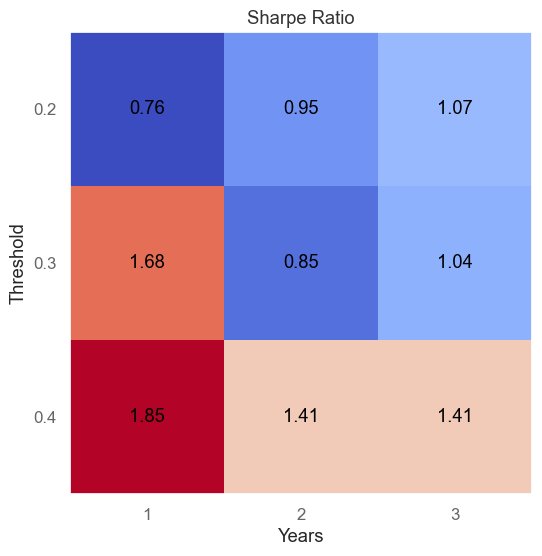

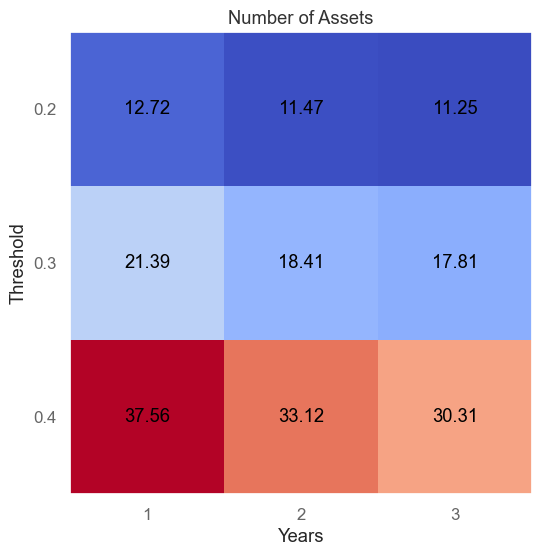

In [5]:

sharpe_ratio_map = np.loadtxt('sharpe_ratio_map.txt', delimiter=',')
num_of_assets_map = np.loadtxt('num_of_assets_map.txt', delimiter=',')

threshold_array = [0.2, 0.3, 0.4]
years_array = [1, 2, 3]

fig, ax = plt.subplots()

cax = ax.imshow(sharpe_ratio_map, cmap='coolwarm')
ax.grid(False)


for i in range(len(threshold_array)):
    for j in range(len(years_array)):
        text = ax.text(j, i, f'{sharpe_ratio_map[i, j]:.2f}', ha='center', va='center', color='black')

ax.set_xticks(np.arange(len(years_array)))
ax.set_yticks(np.arange(len(threshold_array)))
ax.set_xticklabels(years_array)
ax.set_yticklabels(threshold_array)
ax.set_xlabel('Years')
ax.set_ylabel('Threshold')
ax.set_title('Sharpe Ratio')
plt.savefig('sharpe_ratio_map_training.png')

fig, ax = plt.subplots()

cax = ax.imshow(num_of_assets_map, cmap='coolwarm')
ax.grid(False)

for i in range(len(threshold_array)):
    for j in range(len(years_array)):
        text = ax.text(j, i, f'{num_of_assets_map[i, j]:.2f}', ha='center', va='center', color='black')

ax.set_xticks(np.arange(len(years_array)))
ax.set_yticks(np.arange(len(threshold_array)))
ax.set_xticklabels(years_array)
ax.set_yticklabels(threshold_array)
ax.set_xlabel('Years')
ax.set_ylabel('Threshold')
ax.set_title('Number of Assets')
plt.savefig('num_of_assets_map_training.png')



### Optimization of the modern portfolio theory

In [20]:

def modern_portfolio_theory_optimization():
    df_returns = np.log(1+df_2000_2018.pct_change()).dropna()

    #Define and set the number of assets under consideration
    N = len(df_2.columns)

    #Define and set the mean return of the assets
    mu = df_returns.mean().values

    #Define and set the covariance matrix of the returns
    Sigma = df_returns.cov().values

    #Initialize the weight vector as cp.Variable(N) of the cvxpy framework
    w = cp.Variable(N)

    #Investor risk aversion parameter
    risk_aversion = cp.Parameter(nonneg=True)

    #Define how the mean return of the portfolio is computed: ret = w^T * mu
    mean_P = mu.T @ w #(@ performs matrix multiplication in Python)

    #Define how the variance of the portfolio is computed,  w^T*mu*w, which is a quadratic form
    var_P = cp.quad_form(w, Sigma)

    #Define expression to be solved
    expression = cp.Maximize((1-risk_aversion)*mean_P - risk_aversion*var_P)

    ##Define the constraints
    constraints = [cp.sum(w)==1, w>=0]

    #Define the problem
    prob = cp.Problem(expression, constraints)

    SAMPLES = 300

    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    SRs = np.zeros(SAMPLES)

    weights = np.zeros((SAMPLES, N))

    lambda_vals = np.logspace(-5, 0, SAMPLES)

    for i in range(SAMPLES):

        risk_aversion.value = lambda_vals[i]

        prob.solve()

        risk_data[i] = np.sqrt(var_P.value * 252)

        ret_data[i] = mean_P.value*252

        SRs[i] = ret_data[i] / risk_data[i]

        weights[i, :] = w.value

    
    #save the weights
    opt_weights_MV_2 = weights[np.argmax(SRs)]

    np.savetxt('opt_weights_MV_2.txt', [opt_weights_MV_2])

modern_portfolio_theory_optimization()


C:\Users\Mirosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### Returns for each portfolio strategy

In [17]:
start_year = 2000
end_year = 2018

def degeneracy_portfolio_cum_returns(df, start_year, end_year, correlation_years, correlation_threshold):

    set_of_portfolios = portfolios(df, start_year, end_year, correlation_years, correlation_threshold)

    returns=calculate_daily_returns(set_of_portfolios, df, start_year)


    cumulative_returns = (1 + returns).cumprod()-1

    return cumulative_returns, returns



def equally_weighted_portfolio_cum_returns(df,start_year, end_year,correlation_years, correlation_threshold):

    portfolio_EW = first_portfolio(df, 2000, correlation_years, correlation_threshold)

    portfolio_assets_EW = list(portfolio_EW)
    portfolio_df_EW = df.loc[f"{start_year}-01-01":f"{end_year}-12-31", portfolio_assets_EW]

    num_assets = len(portfolio_df_EW.columns)
    weights = np.array([1 / num_assets] * num_assets)

    daily_returns = portfolio_df_EW.pct_change().dropna()

    counter=1
    for i in weights:
        daily_returns.iloc[counter,:] = daily_returns.iloc[counter,:] * i
        counter+=1

    #equally_weighted_returns = np.dot(weights, daily_returns)

    mean_equally_weighted_returns = daily_returns.mean(axis=1)

    #equally_weighted_returns_df = pd.DataFrame(equally_weighted_returns, columns=['Equally Weighted Returns'])

    #mean_daily_returns_selected = equally_weighted_returns_df.mean(axis=1)
    cumulative_returns_selected_market = (1 + mean_equally_weighted_returns).cumprod()-1

    return cumulative_returns_selected_market, mean_equally_weighted_returns



def modern_portfolio_theory_returns():
    Initial_investment = 1

    df_returns = np.log(1+df_2000_2018.pct_change()).dropna()

    P_MV_2 = [Initial_investment]

    opt_weights_MV_2= np.loadtxt('opt_weights_MV_2.txt')

    for i in range(len(df_returns)-1):

        r_MV_2 = np.dot(opt_weights_MV_2, df_returns.iloc[i, :].values)

        P_MV_2.append(P_MV_2[-1]*np.exp(r_MV_2))

    return P_MV_2, df_returns


def modern_portfolio_theory_returns_2019():
    Initial_investment = 1

    df_returns = np.log(1+df_2019_2023.pct_change()).dropna()

    P_MV_2 = [Initial_investment]

    opt_weights_MV_2= np.loadtxt('opt_weights_MV_2.txt')

    for i in range(len(df_returns)-1):

        r_MV_2 = np.dot(opt_weights_MV_2, df_returns.iloc[i, :].values)

        P_MV_2.append(P_MV_2[-1]*np.exp(r_MV_2))

    for i in range(len(P_MV_2)):
        P_MV_2[i] = P_MV_2[i]-1

    return P_MV_2, df_returns


def get_nyse_cumulative_returns(start_year, end_year):
    market_ticker = '^NYA'  # NYSE Composite Index
    
    market_data = yf.download(market_ticker, start=f'{start_year}-01-01', end=f'{end_year-1}-12-31')
    
    market_data['Daily Return'] = market_data['Adj Close'].pct_change().dropna()
    
    market_data['Cumulative Return'] = (1 + market_data['Daily Return']).cumprod() - 1
    
    # Return the cumulative returns DataFrame
    return market_data['Cumulative Return'], market_data['Daily Return']


### Plot the returns for the test data set

In [12]:
def plot_returns(cumulative_returns_nyse, cumulative_returns_degeneracy, cumulative_returns_equally_weighted,cumulativ_returns_MPT,PMV, stard_year, end_year):
    plt.figure()

    plt.plot(cumulative_returns_nyse.index, cumulative_returns_nyse, label='NYSE', linewidth=2, color='green')
    plt.plot(cumulative_returns_degeneracy.index, cumulative_returns_degeneracy, label='Degeneracy Portfolio', linewidth=2, color='red')
    plt.plot(cumulative_returns_equally_weighted.index, cumulative_returns_equally_weighted, label='Equally Weighted Portfolio', linewidth=2, color='blue')
    plt.plot(cumulativ_returns_MPT.index, PMV, label='MPT Portfolio', linewidth=2, color='purple')

    plt.title(f'Cumulative Returns from {stard_year} to {end_year}')
    plt.legend()

    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)

    plt.savefig(f'cumulative_returns_{stard_year}-{end_year}.png')
    plt.show()

"""cumulative_returns_degeneracy,returns_degeneracy=degeneracy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.4)
cumulative_returns_equally_weighted, returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year,end_year,1, 0.4)
nyse_cumulative_returns, nyse_returns = get_nyse_cumulative_returns(start_year, end_year)
P_MV_2, df_returns_model = modern_portfolio_theory_returns()


plot_returns(nyse_cumulative_returns, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, df_returns_model,start_year, end_year)"""



'cumulative_returns_degeneracy,returns_degeneracy=degeneracy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.4)\ncumulative_returns_equally_weighted, returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year,end_year,1, 0.4)\nnyse_cumulative_returns, nyse_returns = get_nyse_cumulative_returns(start_year, end_year)\nP_MV_2, df_returns_model = modern_portfolio_theory_returns()\n\n\nplot_returns(nyse_cumulative_returns, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, df_returns_model,start_year, end_year)'

### The table

In [13]:
def calculate_metrics(returns):

    N = len(returns)
    cumulative_return = (returns + 1).cumprod()
    
    annualized_return = (cumulative_return[-1] ** (252 / N)) - 1
    sharpe_ratio = qs.stats.sharpe(returns)
    volatility = qs.stats.volatility(returns, annualize=True)
    return annualized_return, sharpe_ratio, volatility

def calculate_metrics_MV(P_MV, returns):
    """
    for i in range(len(P_MV)):
        P_MV[i] = P_MV[i]-1
        
    P_MV_series = pd.Series(P_MV, index=returns.index)

    N = len(P_MV_series)
    cumulative_return = (P_MV_series + 1).cumprod()
    
    annualized_return = (cumulative_return[-1] ** (252 / N)) - 1
    sharpe_ratio = qs.stats.sharpe(P_MV_series)
    volatility = qs.stats.volatility(P_MV_series, annualize=True)
    return annualized_return, sharpe_ratio, volatility"""

    annualized_returns = np.mean(np.log(1+pd.DataFrame(P_MV).pct_change()).dropna().values).flatten() * 252

    annualized_volatility = np.std(np.log(1+pd.DataFrame(P_MV).pct_change()).dropna().values).flatten() * np.sqrt(252)

    sharpe_ratios =  annualized_returns / annualized_volatility

    return annualized_returns.item(), sharpe_ratios.item(), annualized_volatility.item()

def get_items(returns_deg, returns_ew, returns_MV,returns_df,returns_nyse):
    # Calculate metrics for each set of returns
    metrics_deg = calculate_metrics(returns_deg)
    metrics_ew = calculate_metrics(returns_ew)
    metrics_MV = calculate_metrics_MV(returns_MV, returns_df)
    metrics_nyse = calculate_metrics(returns_nyse)

    # Create the tickers dictionary
    tickers = {
        'DEG': ('DEG Strategy', *metrics_deg),
        'EW': ('Equal Weight', *metrics_ew),
        'MPT': ('Mean-Variance Portfolio', *metrics_MV),
        'NYSE': ('NYSE', *metrics_nyse),
    }

    return tickers

def get_table_in_latex_format(name_val):

    # Table in LaTeX
    latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{cccccc}\n\\hline\n"
    latex_table += "Market & Annualized Return (\%) & Sharpe ratio (\%) & Annualized Volatility   \\\\\n"
    latex_table += "\\hline\n"

    for ticker, (name, val1, val2, val3) in name_val.items():
        val1, val2, val3 = round(val1, 3), round(val2, 3), round(val3, 3)
        latex_table += f"{name} & {val1} & {val2} & {val3}  \\\\\n"

    latex_table += "\\hline\n\\end{tabular}\n\\caption{}\n\\end{table}"

    # Imprimir la tabla LaTeX generada
    print(latex_table)

"""cumulative_returns_degeneracy,returns_degeneracy=degeneracy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.4)
cumulative_returns_equally_weighted, returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year,end_year,1, 0.4)
nyse_cumulative_returns, nyse_returns = get_nyse_cumulative_returns(start_year, end_year)
P_MV_2, df_returns_model = modern_portfolio_theory_returns()

results = get_items(returns_degeneracy, returns_equally_weighted, P_MV_2, df_returns_model,nyse_returns)
get_table_in_latex_format(results)"""




'cumulative_returns_degeneracy,returns_degeneracy=degeneracy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.4)\ncumulative_returns_equally_weighted, returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year,end_year,1, 0.4)\nnyse_cumulative_returns, nyse_returns = get_nyse_cumulative_returns(start_year, end_year)\nP_MV_2, df_returns_model = modern_portfolio_theory_returns()\n\nresults = get_items(returns_degeneracy, returns_equally_weighted, P_MV_2, df_returns_model,nyse_returns)\nget_table_in_latex_format(results)'

### Plotting the test data set

[*********************100%%**********************]  1 of 1 completed
C:\Users\Mirosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


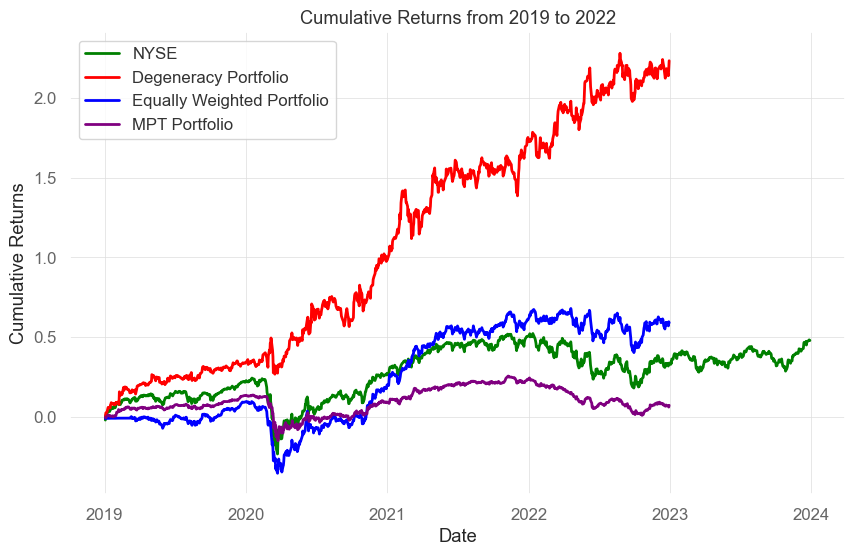

In [18]:
start_year = 2019
end_year = 2023

def plot_returns_2019(cumulative_returns_nyse, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, cumulative_returns_MPT, P_MV_2,stard_year, end_year):
    plt.figure()

    plt.plot(cumulative_returns_nyse.index, cumulative_returns_nyse, label='NYSE', linewidth=2, color='green')
    plt.plot(cumulative_returns_degeneracy.index, cumulative_returns_degeneracy, label='Degeneracy Portfolio', linewidth=2, color='red')
    plt.plot(cumulative_returns_equally_weighted.index, cumulative_returns_equally_weighted, label='Equally Weighted Portfolio', linewidth=2, color='blue')
    plt.plot(cumulative_returns_MPT.index, P_MV_2, label='MPT Portfolio', linewidth=2, color='purple')

    plt.title(f'Cumulative Returns from {stard_year} to {end_year-1}')
    plt.legend()

    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)

    plt.savefig(f'cumulative_returns_{stard_year}-{end_year-1}.png')
    plt.show()

cumulative_returns_degeneracy,returns_degeneracy=degeneracy_portfolio_cum_returns(df_2, start_year, end_year, 1, 0.4)
cumulative_returns_equally_weighted, returns_equally_weighted = equally_weighted_portfolio_cum_returns(df_2, start_year,end_year,1, 0.4)
nyse_cumulative_returns, nyse_returns = get_nyse_cumulative_returns(start_year, end_year)
P_MV, df_returns_model = modern_portfolio_theory_returns_2019()


plot_returns_2019(nyse_cumulative_returns, cumulative_returns_degeneracy, cumulative_returns_equally_weighted, df_returns_model, P_MV,start_year, end_year)



In [58]:
results = get_items(returns_degeneracy, returns_equally_weighted, P_MV, df_returns_model,nyse_returns)
get_table_in_latex_format(results)

\begin{table}[h!]
\centering
\begin{tabular}{cccccc}
\hline
Market & Annualized Return (\%) & Sharpe ratio (\%) & Annualized Volatility   \\
\hline
DEG Strategy & 0.789 & 1.327 & 0.519  \\
Equal Weight & 0.123 & 0.593 & 0.247  \\
Mean-Variance Portfolio & 0.358 & 0.08 & 4.491  \\
NYSE & 0.075 & 0.439 & 0.219  \\
\hline
\end{tabular}
\caption{}
\end{table}


C:\Users\Mirosh\AppData\Local\Temp\ipykernel_1892\3418450350.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return = (cumulative_return[-1] ** (252 / N)) - 1
C:\Users\Mirosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\Mirosh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\Mirosh\AppData\Local\Temp\ipykernel_1892\3418450350.py:6: FutureWarning: Series.__getitem__ treatin